<a href="https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/particle_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Particle Filters for Mobile Robot Localization

We have a robot.  Our poor robot don't know where it is, but it wants to know.  And the robot has a map that is known to be pretty accurate.  We consider a probability distribution over where it might be.  Right now, that is pretty uniform, but it will change in strange ways - it may have a strong peak, or a weak peak and gentle slope.  Or if there is symmetry in the environment, such as a long corridor with uniformly-spaced identical doors, our distribution might have multiple peaks.  So we can't represent our probability distribution with a nice clean Gaussian or some other canonical distribution.

## Representing the probability distribution
So let's maintain a population of samples, each giving a guess at a possible pose of our robot (**x**,**y**, and $\theta$).  There are a few things we can do with these samples.  
- As our robot moves through the environment, we can move these samples around to track its movement.
- As its sensors perceive the landmarks in the world, we can weight those samples according to how likely those sensor readings are given that the robot is in that particular pose.
- And at regular intervals, we can pull a new set of samples from the weighted distribution represented by our current generation of samples.
If all goes well, this will let us track where our robot is, and even handle cases where our robot is kidnapped to an unexpected location in the world.

You can think of this as being similar to a Genetic Algorithm.  GAs keep a population of individuals, each one representing a guess at the optimal solution.  Through mutation and cross-over, the individuals (in theory) gravitate toward that optimal solution.  We have samples here too, except we will be using probability and statistics to generate the next generation of samples, not random mutation and cross-over.

## Importance Sampling
Let's start with a simple, uniform distribution.  We draw our constant function in green, showing that all poses are equally likely.  Underneath, we draw in some randomly chosen samples that represent our distribution.  Note that the distribution they represent is NOT uniform.  But with more samples, it would be more faithful.

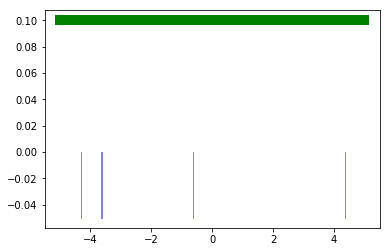

In [0]:
import scipy.stats as stats
import math
import random


xs = np.linspace(-5,5, 100)
ys = np.array([0.1 for i in xs])
plt.plot(x, ys, color='g', linewidth=10)

sampleX=[random.random()*10-5 for i in range(5)]

dummy=[plt.plot((i,i), (-0.05, 0), linewidth=1, color='b', alpha=0.5) for i in sampleX]

Let's say our sensors locate a few interesting landmarks, and these landmarks indicate that poses near zero were more likely.  And let's say that relationship just happens to follow a perfect cosine wave.  Then we can weight our samples according to that cosine.  (In practice, we'd weight the samples according to how believable the sensor reading would be given that it was taken from a robot at the corresponding pose.  We're just using the cosine as a convenient way to pretend we are doing that.)

[0.180311249295192, 0.16712484909634323, 0.038385750122769735, 0.9600705406639829, 0.04640138160918056]


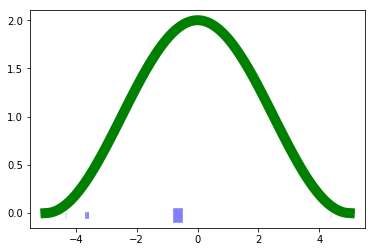

In [0]:
import scipy.stats as stats
import math

#xs = np.linspace(-5,5, 100)
ys = np.array([math.cos(i*math.pi/5)+1 for i in xs])
plt.plot(xs, ys, color='g', linewidth=10)
ws = [(math.cos(i*math.pi/5)+1)/2 for i in sampleX] # all weights 0..2
print(ws)
dummy=[plt.plot((i,i), (-0.05, 0), linewidth=5*(math.cos(i*math.pi/5)+1), color='b', alpha=0.5) for i in sampleX]

The weighted samples towards the center represent believable sensor readings, and consequently are stronger and carry more weight.  Conversely, the ones further off to the sides are unlikely, and so they look weak and pathetic.  Together, the samples and their corresponding weights represent a new probability distribution.  Let's resample from this probability distribution and get a new population of samples.

In [0]:
from numpy.random import uniform

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, numpy.random.random(N))

    # resample according to indexes
    print("particles: "+str(particles))
    print("indexes: "+str(indexes))
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
print(sampleX)
sumWs = sum(ws)
print(ws)
print(sumWs)

ws=[q/sumWs for q in ws]
print(ws)
print(sum(ws))

simple_resample(sampleX,ws)
print(sampleX)

# plot from the xs set (the new resampled set)
dummy=[plt.plot((i,i), (-0.05, 0), linewidth=1, color='b', alpha=0.5) for i in sampleX]



[-3.60403936097251, -3.659442007603837, 4.372297943650306, -0.6403690061037439, -4.308912753973014]
[0.12950661209466566, 0.12003562222491232, 0.02757015144947399, 0.6895603218284716, 0.033327292402476505]
1.0
[0.12950661209466566, 0.12003562222491232, 0.02757015144947399, 0.6895603218284716, 0.033327292402476505]
1.0
particles: [-3.60403936097251, -3.659442007603837, 4.372297943650306, -0.6403690061037439, -4.308912753973014]
indexes: [3 1 3 3 2]


TypeError: ignored

Our new samples are now much more strongly 

# Particle Filters
This next section is a modified excerpt from https://notebooks.gesis.org/binder/jupyter/user/rlabbe-kalman-a-lters-in-python-lue6bp20/notebooks/12-Particle-Filters.ipynb by that [Roger Labbe](https://github.com/rlabbe) guy who wrote filterpy.

In [0]:
!pip install filterpy

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform

## The Particle Filter

All of this brings us to the particle filter. Consider tracking a robot or a car in an urban environment. For consistency I will use the robot localization problem from the EKF and UKF chapters. In this problem we tracked a robot that has a sensor which measures the range and bearing to known landmarks. 

Particle filters are a family of algorithms. I'm presenting a specific form of a particle filter that is intuitive to grasp and relates to the problems we have studied in this book. This will leave a few of the steps seeming a bit 'magical' since I haven't offered a full explanation. That will follow later in the chapter.

Taking insight from the discussion in the previous section we start by creating several thousand *particles*. Each particle has a position that represents a possible belief of where the robot is in the scene, and perhaps a heading and velocity. Suppose that we have no knowledge of the location of the robot. We would want to scatter the particles uniformly over the entire scene. If you think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief, and locations with fewer particles represents a lower belief. If there was a large clump of particles near a specific location that would imply that we were more certain that the robot is there.

Each particle needs a weight - ideally the probability that it represents the true position of the robot. This probability is rarely computable, so we only require it be *proportional*  to that probability, which is computable. At initialization we have no reason to favor one particle over another, so we assign a weight of $1/N$, for $N$ particles. We use $1/N$ so that the sum of all probabilities equals one.

The combination of particles and weights forms the *probability distribution* for our problem. Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. This is very similar except the particles are randomly distributed in a continuous space rather than constrained to discrete locations. In this problem the robot can move on a plane of some arbitrary dimension, with the lower right corner at (0,0).

To track our robot we need to maintain states for x, y, and heading. We will store `N` particles in a `(N, 3)` shaped array. The three columns contain x, y, and heading, in that order. 

If you are passively tracking something (no control input), then you would need to include velocity in the state and use that estimate to make the prediction. More dimensions requires exponentially more particles to form a good estimate, so we always try to minimize the number of random variables in the state.

This code creates a uniform and Gaussian distribution of particles over a region:

In [0]:
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles
  
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.45273135, 0.40378195, 0.15494843],
       [0.69555751, 0.28088435, 1.78345432],
       [0.62917083, 0.70240335, 5.91489106],
       [0.81019735, 0.9871471 , 1.61382831]])

### Predict Step

The predict step in the Bayes algorithm uses the process model to update the belief in the system state. How would we do that with particles? Each particle represents a possible position for the robot. Suppose we send a command to the robot to move 0.1 meters while turning by 0.007 radians. We could move each particle by this amount. If we did that we would soon run into a problem. The robot's controls are not perfect so it will not move exactly as commanded. Therefore we need to add noise to the particle's movements to have a reasonable chance of capturing the actual movement of the robot. If you do not model the uncertainty in the system the particle filter will not correctly model the probability distribution of our belief in the robot's position.

In [0]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

### Update Step

Next we get a set of measurements - one for each landmark currently in view. How should these measurements be used to alter our probability distribution as modeled by the particles?

Think back to the **Discrete Bayes** chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. We assigned a probability to each position which we called the *prior*. When a new measurement came in we multiplied the current probability of that position (the *prior*) by the *likelihood* that the measurement matched that location:

```python
def update(likelihood, prior):
    posterior = prior * likelihood
    return normalize(posterior)
```

which is an implementation of the equation

$$x = \| \mathcal L \bar x \|$$

which is a realization of Bayes theorem:

$$\begin{aligned}P(x \mid z) &= \frac{P(z \mid x)\, P(x)}{P(z)} \\
 &= \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}\end{aligned}$$
 
We do the same with our particles. Each particle has a position and a weight which estimates how well it matches the measurement. Normalizing the weights so they sum to one turns them into a probability distribution. The particles those that are closest to the robot will generally have a higher weight than ones far from the robot. 

In [0]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In the literature this part of the algorithm is called *Sequential Importance Sampling*, or SIS. The equation for the weights is called the *importance density*. I will give these theoretical underpinnings in a following section. For now I hope that this makes intuitive sense. If we weight the particles according to how well they match the measurements they are probably a good sample for the probability distribution of the system after incorporating the measurements. Theory proves this is so. The weights are the *likelihood* in Bayes theorem. Different problems will need to tackle this step in slightly different ways but this is the general idea.

### Computing the State Estimate

In most applications you will want to know the estimated state after each update, but the filter consists of nothing but a collection of particles. Assuming that we are tracking one object (i.e. it is unimodal) we can compute the mean of the estimate as the sum of the weighted values of the particles. 

$$ \mu = \frac{1}{N}\sum\limits_{i=1}^N w^ix^i$$

Here I adopt the notation $x^i$ to indicate the i$^{th}$ particle. A superscript is used because we often need to use subscripts to denote time steps the k$^{th}$ or k+1$^{th}$ particle, yielding the unwieldy $x^i_{k+1}$. 

This function computes both the mean and variance of the particles:

In [0]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

If we create a uniform distribution of points in a 1x1 square with equal weights we get a mean position very near the center of the square at (0.5, 0.5) and a small variance.

In [0]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.5291742 , 0.50177102]), array([0.08549041, 0.08121073]))

### Particle Resampling

The SIS algorithm suffers from the *degeneracy problem*. It starts with uniformly distributed particles with equal weights. There may only be a handful of particles near the robot. As the algorithm runs any particle that does not match the measurements will acquire an extremely low weight. Only the particles which are near the robot will have an appreciable weight. We could have 5,000 particles with only 3 contributing meaningfully to the state estimate! We say the filter has *degenerated*.This problem is usually solved by some form of *resampling* of the particles. 

Particles with very small weights do not meaningfully describe the probability distribution of the robot. The resampling algorithm discards particles with very low probability and replaces them with new particles with higher probability. It does that by duplicating particles with relatively high probability. The duplicates are slightly dispersed by the noise added in the predict step. This results in a set of points in which a large majority of the particles accurately represent the probability distribution.

There are many resampling algorithms.  For now let's look at one of the simplest, *simple random resampling*, also called *multinomial resampling*. It samples from the current particle set $N$ times, making a new set of particles from the sample. The probability of selecting any given particle should be proportional to its weight.

We accomplish this with NumPy's `cumsum` function. `cumsum` computes the cumulative sum of an array. That is, element one is the sum of elements zero and one, element two is the sum of elements zero, one and two, etc. Then we generate random numbers in the range of 0.0 to 1.0 and do a binary search to find the weight that most closely matches that number:

In [0]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

We don't resample at every epoch. For example, if you received no new measurements you have not received any information from which the resample can benefit. We can determine when to resample by using something called the *effective N*, which approximately measures the number of particles which meaningfully contribute to the probability distribution. The equation for this is

$$\hat{N}_\text{eff} = \frac{1}{\sum w^2}$$

and we can implement this in Python with

In [0]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

If $\hat{N}_\text{eff}$ falls below some threshold it is time to resample. A useful starting point is $N/2$, but this varies by problem. It is also possible for $\hat{N}_\text{eff} = N$, which means the particle set has collapsed to one point (each has equal weight). It may not be theoretically pure, but if that happens I create a new distribution of particles in the hopes of generating particles with more diversity. If this happens to you often, you may need to increase the number of particles, or otherwise adjust your filter. We will talk more of this later.

## SIR Filter  - A Complete Example

There is more to learn, but we know enough to implement a full particle filter. We will implement the *Sampling Importance Resampling filter*, or SIR.

I need to introduce a more sophisticated resampling method than I gave above. FilterPy provides several resampling methods. I will describe them later. They take an array of weights and returns indexes to the particles that have been chosen for the resampling. We just need to write a function that performs the resampling from these indexes:

In [0]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))

To implement the filter we need to create the particles and the landmarks. We then execute a loop, successively calling `predict`, `update`, resampling, and then computing the new state estimate with `estimate`.

final position error, variance:
	 [-0.10621456  0.1061402 ] [0.00859646 0.00757081]


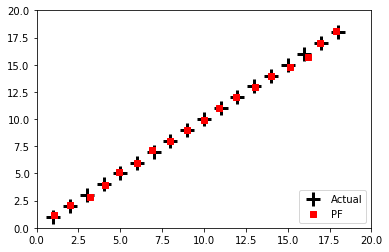

In [0]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

Most of this code is devoted to initialization and plotting. The entirety of the particle filter processing consists of these lines:

```python
# move diagonally forward to (x+1, x+1)
predict(particles, u=(0.00, 1.414), std=(.2, .05))

 # incorporate measurements
update(particles, weights, z=zs, R=sensor_std_err, 
       landmarks=landmarks)
       
# resample if too few effective particles
if neff(weights) < N/2:
    indexes = systematic_resample(weights)
    resample_from_index(particles, weights, indexes)

mu, var = estimate(particles, weights)
```

The first line predicts the position of the particles with the assumption that the robot is moving in a straight line (`u[0] == 0`) and moving 1 unit in both the x and y axis (`u[1]==1.414`). The standard deviation for the error in the turn is 0.2, and the standard deviation for the distance is 0.05. When this call returns the particles will all have been moved forward, but the weights are no longer correct as they have not been updated.

The next line incorporates the measurement into the filter. This does not alter the particle positions, it only alters the weights. If you recall the weight of the particle is computed as the probability that it matches the Gaussian of the sensor error model. The further the particle from the measured distance the less likely it is to be a good representation.

The final two lines example the effective particle count ($\hat{N}_\text{eff})$. If it falls below $N/2$ we perform resampling to try to ensure our particles form a good representation of the actual probability distribution.

Now let's look at this with all the particles plotted. Seeing this happen interactively is much more instructive, but this format still gives us useful information. I plotted the original random distribution of points in a very pale green and large circles to help distinguish them from the subsequent iterations where the particles are plotted with black pixels. The number of particles makes it hard to see the details, so I limited the number of iterations to 8 so we can zoom in and look more closely.

final position error, variance:
	 [-0.01868509 -0.00526306] [0.00515279 0.00559609]


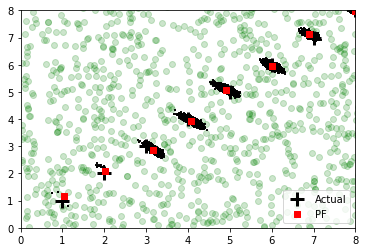

In [0]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

From the plot it looks like there are only a few particles at the first two robot positions. This is not true; there are 5,000 particles, but due to resampling most are duplicates of each other. The reason for this is the Gaussian for the sensor is very narrow. This is called *sample impoverishment* and can lead to filter divergence. I'll address this in detail below. For now, looking at the second step at x=2 we can see that the particles have dispersed a bit. This dispersion is due to the motion model noise. All particles are projected forward according to the control input `u`, but noise is added to each particle proportional to the error in the control mechanism in the robot. By the third step the particles have dispersed enough to make a convincing cloud of particles around the robot. 

The shape of the particle cloud is an ellipse. This is not a coincidence. The sensors and robot control are both modeled as Gaussian, so the probability distribution of the system is also a Gaussian. The particle filter is a sampling of the probability distribution, so the cloud should be an ellipse.

It is important to recognize that the particle filter algorithm *does not require* the sensors or system to be Gaussian or linear. Because we represent the probability distribution with a cloud of particles we can handle any probability distribution and strongly nonlinear problems. There can be discontinuities and hard limits in the probability model. 

### Effect of Sensor Errors on the Filter

The first few iterations of the filter resulted in many duplicate particles. This happens because the model for the sensors is Gaussian, and we gave it a small standard deviation of $\sigma=0.1$. This is  counterintuitive at first. The Kalman filter performs better when the noise is smaller, yet the particle filter can perform worse.


We can reason about why this is true. If $\sigma=0.1$, the robot is at (1, 1) and a particle is at (2, 2) the particle is 14 standard deviations away from the robot. This gives it a near zero probability. It contributes nothing to the estimate of the mean, and it is extremely unlikely to survive after the resampling. If $\sigma=1.4$ then the particle is only $1\sigma$ away and thus it will contribute to the estimate of the mean. During resampling it is likely to be copied one or more times.

This is *very important* to understand - a very accurate sensor can lead to poor performance of the filter because few of the particles will be a good sample of the probability distribution. There are a few fixes available to us. First, we can artificially increase the sensor noise standard deviation so the particle filter will accept more points as matching the robots probability distribution. This is non-optimal because some of those points will be a poor match. The real problem is that there aren't enough points being generated such that enough are near the robot. Increasing `N` usually fixes this problem. This decision is not cost free as increasing the number of particles significantly increase the computation time. Still, let's look at the result of using 100,000 particles.

final position error, variance:
	 [-0.17032514  0.08449354] [0.00548215 0.00500979]


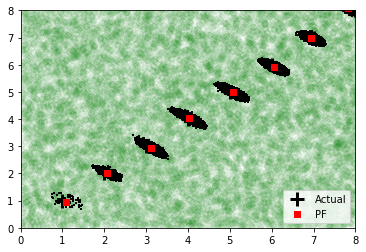

In [0]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

There are many more particles at x=1, and we have a convincing cloud at x=2. Clearly the filter is performing better, but at the cost of large memory usage and long run times.

Another approach is to be smarter about generating the initial particle cloud. Suppose we guess that the robot is near (0, 0). This is not exact, as the simulation actually places the robot at (1, 1), but it is close. If we create a normally distributed cloud near (0, 0) there is a much greater chance of the particles matching the robot's position.

`run_pf1()` has an optional parameter `initial_x`. Use this to specify the initial position guess for the robot. The code then uses `create_gaussian_particles(mean, std, N)` to create particles distributed normally around the initial guess. We will use this in the next section.

### Filter Degeneracy From Inadequate Samples

The filter as written is far from perfect. Here is how it performs with a different random seed.

final position error, variance:
	 [ -2.68752498 -31.47031509] [47.06523888 47.03048468]


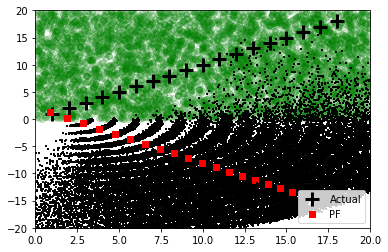

In [0]:
seed(6) 
run_pf1(N=5000, plot_particles=True, ylim=(-20, 20))

Here the initial sample of points did not generate any points near the robot. The particle filter does not create new points during the resample operation, so it ends up duplicating points which are not a representative sample of the probability distribution. As mentioned earlier this is called *sample impoverishment*. The problem quickly spirals out of control. The particles are not a good match for the landscape measurement so they become dispersed in a highly nonlinear, curved distribution, and the particle filter diverges from reality. No particles are available near the robot, so it cannot ever converge.

Let's make use of the `create_gaussian_particles()` method to try to generate more points near the robot. We can do this by using the `initial_x` parameter to specify a location to create the particles.

final position error, variance:
	 [ 0.03533921 -0.07658383] [0.0074115  0.00932576]


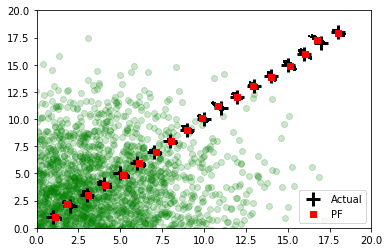

In [0]:
seed(6) 
run_pf1(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

This works great. You should always try to create particles near the initial position if you have any way to roughly estimate it. Do not be *too* careful - if you generate all the points very near a single position the particles may not be dispersed enough to capture the nonlinearities in the system. This is a fairly linear system, so we could get away with a smaller variance in the distribution. Clearly this depends on your problem. Increasing the number of particles is always a good way to get a better sample, but the processing cost may be a higher price than you are willing to pay.

# Resources
- https://notebooks.gesis.org/binder/jupyter/user/rlabbe-kalman-a-lters-in-python-lue6bp20/tree : a book in notebook form.  It will take some coaxing to make it work with colab, but it seems to work here.  Chapter 12 (Particle Filters) is the most relevant to this discussion.
- https://en.wikipedia.org/wiki/Monte_Carlo_localization : a "simple" definition without Kalman filters.
- https://en.wikipedia.org/wiki/Simultaneous_localization_and_mapping : SLAM uses particle filters to localize and map at the same time.
- http://robots.stanford.edu/papers/montemerlo.fastslam-tr.pdf : Fast SLAM (and it's successors) offers greater performance.